In [23]:
import umap
import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

###   t-SNE, UMAP and LargeVis

In this and the next notebook we will use manifold learning for data visualization of large data sets (with high dimensionality). In addition to t-SNE, two relatively new methods will be used that are more efficient on large data sets.


- UMAP (Uniform Manifold Approximation and Projection) - Install this Python package: https://umap-learn.readthedocs.io/en/latest/index.html. UMAP package is compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. UMAP can work as a drop in replacement for t-SNE and other dimension reduction classes from scikit-learn


- LargeVis (Visualizing Large-scale and High-dimensional Data) - Many techniques (like t-SNE, UMAP and LargeVis) first compute a similarity structure of the data points and then project them into a low-dimensional space with the structure preserved. These two steps suffer from considerable computational costs Comparing to tSNE, LargeVis significantly reduces the computational cost of the graph construction step and employs a principled probabilistic model for the visualization step, the objective of which can be effectively optimized through asynchronous stochastic gradient descent with a linear time complexity. Download this algorithm repository and follow the installation instructions. https://github.com/lferry007/LargeVis


In [24]:
from sklearn.manifold import TSNE
import umap

To get data we use the sklearn.datasets.fetch_openml method, which as the name requires, Fetch dataset from openml by name or dataset id. We will use MNIST and Fashion-MNIST(Zalando's article images). Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. Instead of numbers it contains thumbnails of clothes images.

In [25]:
mnist = sklearn.datasets.fetch_openml('mnist_784')
fmnist = sklearn.datasets.fetch_openml('Fashion-MNIST')

Below are drawings of some samples from mnist and fmnist data sets

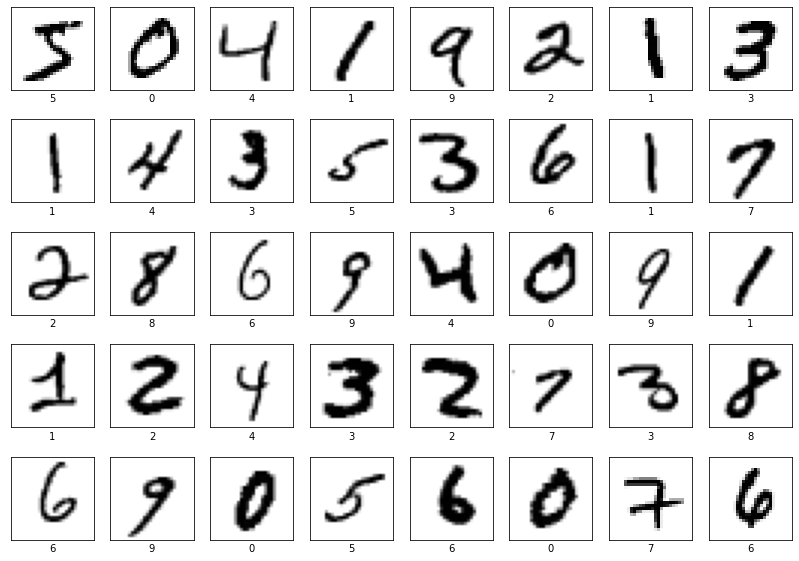

In [26]:
mnist_names = [i for i in range(10)]
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(mnist_names[int(mnist.target[i])])
plt.show()

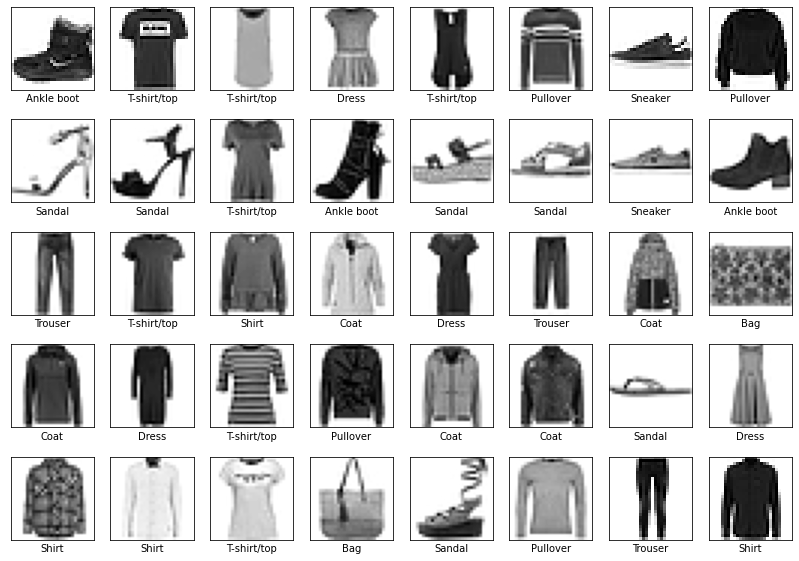

In [27]:
fmnist_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(fmnist_names[int(fmnist.target[i])])
plt.show()

#### Use t-SNE, UMAP and LargeVis to project mnist and fmnist data sets into a 2-dimensional space. For LargeVis, you need to create a function that saves the data to the required by LargeVis txt file format, and a function that loads the resulting file. Draw charts for all visualizations.

In [28]:
def show_visualization(transformed_data, targets):
    fig, ax = plt.subplots()
    fig.set_size_inches(12,9)
    colors = sn.color_palette('bright')
    for index, point in enumerate(transformed_data):
        target = int(targets[index])
        ax.scatter(point[0], point[1], c = np.atleast_2d(colors[target]), label=target)
    ax.legend(np.unique(targets))
    plt.show()

In [29]:
def prepare_largevis_data(data, filename):
    with open(filename, 'w+') as largevis_file:
        largevis_file.write('{} {}\n'.format(data.shape[0], data.shape[1]))
        for line in data:
            largevis_file.write(' '.join(line) + '\n')

In [30]:
mnist.data.shape

(70000, 784)

In [31]:
mnist_data_reduced = mnist.data[:3000]
mnist_tsne = TSNE(n_components=2, metric='euclidean', perplexity=30).fit_transform(mnist_data_reduced)
print(mnist_tsne)

[[ 33.364544   10.415575 ]
 [ 13.084725   68.65381  ]
 [ 51.991207  -41.026615 ]
 ...
 [ -7.1796565 -46.01076  ]
 [-59.33734     8.307141 ]
 [ 23.645252   -4.41946  ]]


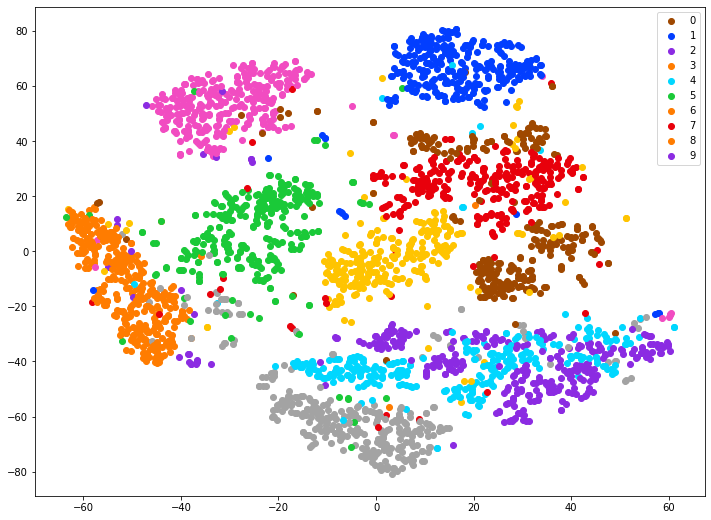

In [32]:
show_visualization(mnist_tsne, mnist.target)

In [33]:
mnist_umap = umap.UMAP(n_components=2).fit_transform(mnist_data_reduced)

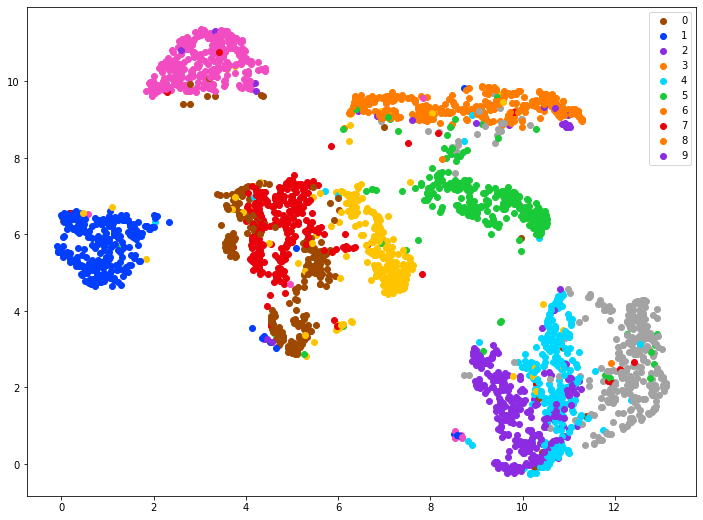

In [34]:
show_visualization(mnist_umap, mnist.target)

In [35]:
fmnist.data.shape

(70000, 784)

In [36]:
fmnist_data_reduced = fmnist.data[:3000]
fmnist_tsne = TSNE(n_components=2, metric='euclidean', perplexity=30).fit_transform(fmnist_data_reduced)

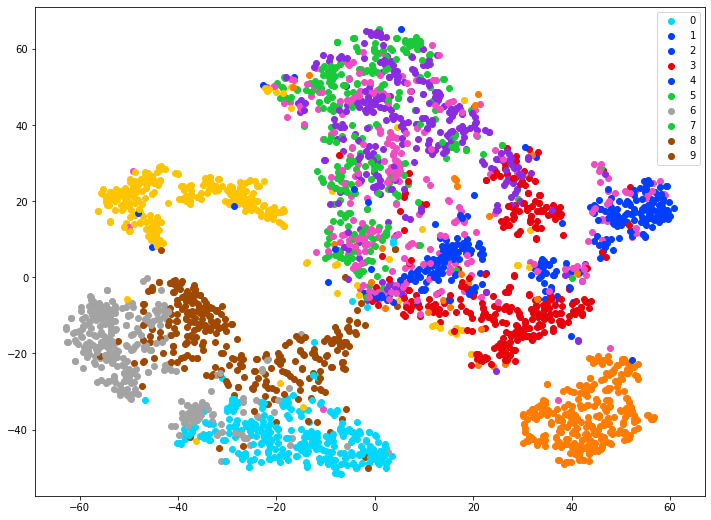

In [37]:
show_visualization(fmnist_tsne, fmnist.target)

In [38]:
fmnist_umap = umap.UMAP(n_components=2).fit_transform(fmnist_data_reduced)

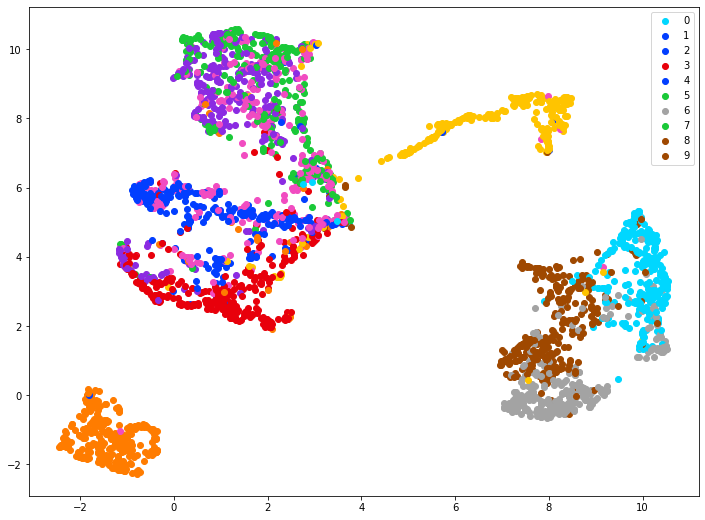

In [39]:
show_visualization(fmnist_umap, fmnist.target)

In [40]:
prepare_largevis_data(mnist_data_reduced[:100, :].astype('str'), 'mloo.txt')
prepare_largevis_data(fmnist_data_reduced.astype('str'), 'fmnist_data.txt')

Plotting LargeVis results. LargeVis visualisation was performed using official LargeVis cpp implementation.

In [80]:
def plot_large_vis(file_name, target):
    with open(file_name) as f:
        lines = f.readlines()
        x = [float(line.split()[0]) for line in lines[1:]]
        y = [float(line.split()[1]) for line in lines[1:]]
        data = np.asarray([y, x])
        data = np.rot90(data, axes=(1,0))
        show_visualization(data, target)
        return data

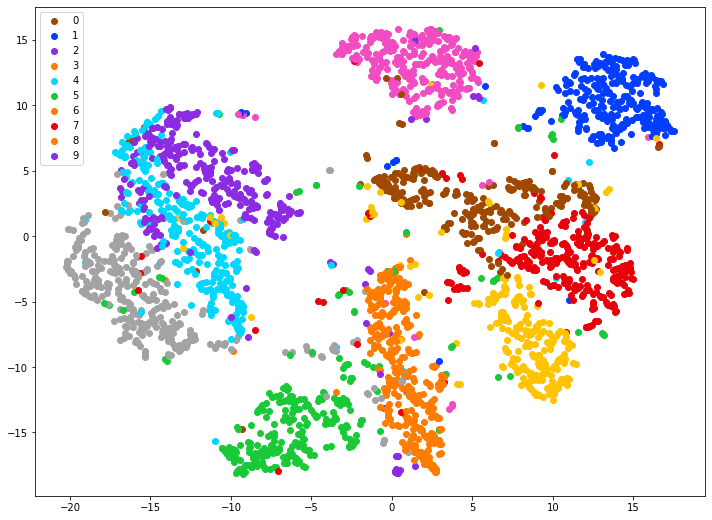

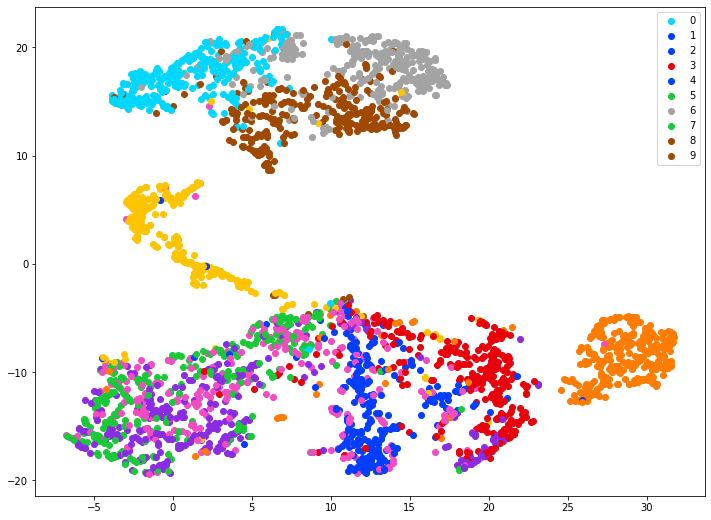

In [81]:
mnist_large_vis = plot_large_vis('mnist_out.txt', mnist.target)
fmnist_large_vis = plot_large_vis('fmnist_out.txt', fmnist.target)

#### In order to compare the results of these three methods, calculate for each case the average distance between two points belonging to the same class divided by the average distance between points belonging to 2 different classes

In [82]:
import math

In [83]:
def calculate_quality_measure(data, targets):
    same_classes_dist_sum = 0
    diff_classes_dist_sum = 0
    same_classes_comparisons = 0
    diff_classes_comparisons = 0
    groups = {digit : [] for digit in range(10)}
    for point, target in zip(data, targets):
        groups[int(target)].append(point)
    for group1, points1 in groups.items():
        for group2, points2 in groups.items():
            for point1 in points1:
                for point2 in points2:
                    dist = math.hypot(point2[0] - point1[0], point2[1] - point1[1])
                    if group1 == group2:
                        same_classes_comparisons += 1
                        same_classes_dist_sum += dist
                    else:
                        diff_classes_comparisons += 1
                        diff_classes_dist_sum += dist
    return (same_classes_dist_sum / same_classes_comparisons) / (diff_classes_dist_sum / diff_classes_comparisons)

In [84]:
print('MNIST tSNE: ', calculate_quality_measure(mnist_tsne, mnist.target[:len(mnist_tsne)]))
print('MNIST UMAP: ', calculate_quality_measure(mnist_umap, mnist.target[:len(mnist_umap)]))
print('MNIST LargeVis: ', calculate_quality_measure(mnist_large_vis, mnist.target[:len(mnist_large_vis)]))
print('FMNIST tSNE: ', calculate_quality_measure(fmnist_tsne, fmnist.target[:len(fmnist_tsne)]))
print('FMNIST UMAP: ', calculate_quality_measure(fmnist_umap, fmnist.target[:len(fmnist_umap)]))
print('FMNIST LargeVis: ', calculate_quality_measure(fmnist_large_vis, fmnist.target[:len(fmnist_large_vis)]))

MNIST tSNE:  0.35853546977055817
MNIST UMAP:  0.30341562294056246
MNIST LargeVis:  0.34084572309452116
FMNIST tSNE:  0.3859995738380458
FMNIST UMAP:  0.29874358310697857
FMNIST LargeVis:  0.3160959797906284


We can see, that in both cases UMAP had the best performance (according to our metric), the second place belongs to LargeVis although the method itself does not have a convenient interface, it requires cpp compilation, txt files parsing and relatively long computation. The least 'correct' method in terms of dimension reduction is tSNE, so UMAP and LargeVis seem like real improvements. 

Visualization produced by all three methods look similarly, so considering reasonable computation time, UMAP may be a first way to go when trying to reduce data dimensions.